In [ ]:
!pip install gym[atari,accept-rom-license]==0.21.0

In [ ]:
import torch
import torch.nn as nn


class DQN(nn.Module):
    def __init__(self, d_in, n_action):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=d_in, out_channels=16, kernel_size=8, stride=4)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=4, stride=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.lr1 = nn.Linear(in_features=9*9*32, out_features=512)
        self.output = nn.Linear(in_features=512, out_features=n_action)

    def forward(self, x):
        x = torch.relu(self.bn1(self.conv1(x)))
        x = torch.relu(self.bn2(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = torch.relu(self.lr1(x))
        x = self.output(x)
        return x


In [ ]:
import torch.nn.functional as F

class DQN2(nn.Module):
    def __init__(self, d_in, n_action):
        super(DQN2, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=d_in, out_channels=32, kernel_size=3)
        size = 84-3+1
        self.mp1 = nn.MaxPool2d(3, 2)
        size = int(np.floor((size - 3)/2)+1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=5)
        size = size - 5 + 1
        self.mp2 = nn.MaxPool2d(3,2)
        size = int(np.floor((size - 3)/2)+1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=7)
        size = size - 7 + 1
        self.mp3 = nn.MaxPool2d(3,2)
        size = int(np.floor((size - 3)/2)+1)
        self.lr1 = nn.Linear(in_features=size * size * 64, out_features=256)
        self.lr2 = nn.Linear(in_features=256, out_features=128)
        self.lr3 = nn.Linear(in_features=128, out_features=256)
        self.lr4 = nn.Linear(in_features=256, out_features=32)
        self.output = nn.Linear(in_features=32, out_features=n_action)

    def forward(self, x):
        x = torch.relu(self.mp1(self.conv1(x)))
        x = torch.relu(self.mp2(self.conv2(x)))
        x = torch.relu(self.mp3(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = torch.relu(self.lr1(x))
        x = torch.relu(self.lr2(x))
        x = torch.relu(self.lr3(x))
        x = torch.relu(self.lr4(x))
        x = self.output(x)
        return x

In [ ]:
cuda0 = torch.device('cuda:0')

In [ ]:
from collections import deque
import numpy as np
import torch
from torch import optim
import cv2
import random


MAX_REPLAY_SIZE = 50000
MIN_REPLAY_SIZE = 40000
BATCH_SIZE = 64


class Agent:
    def __init__(self, env, DQN_TYPE):
        self.env = env
        self.state_h = env.observation_space.shape[0]
        self.state_w = env.observation_space.shape[1]
        self.action_n = env.action_space.n
        self.replay = deque(maxlen=MAX_REPLAY_SIZE)
        self.step = 0
        self.epsilon = 1

        self.mdl = DQN_TYPE(4, self.action_n).to(cuda0)
        self.target_mdl = DQN_TYPE(4, self.action_n).to(cuda0)
        self.optimizer = optim.Adam(self.mdl.parameters(), lr=0.0001)

    def processImage(self, img):
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img_gray = cv2.resize(img_gray, (84, 84))
        return img_gray

    def predict(self, state):
        if random.uniform(0, 1) <= self.epsilon:
          return random.randrange(self.action_n)
        with torch.no_grad():
            state_t = torch.tensor(state, dtype=torch.float, device=cuda0)
            vals = self.mdl.forward(state_t)
            next_action = torch.argmax(vals).item()

        return next_action

    def collect_experience(self, state, action, reward, next_state, done):
        self.replay.append((state, action, reward, next_state, done))

    def train(self):
        if len(self.replay) < MIN_REPLAY_SIZE:
            return 0
        s, a, r, n_s, done = zip(*random.sample(self.replay, BATCH_SIZE))
        s = np.concatenate(s)
        n_s = np.concatenate(n_s)
        r = torch.tensor(r, dtype=torch.float, device=cuda0)
        done = torch.tensor(done, dtype=torch.float, device=cuda0)
        q_vals_all = self.mdl(torch.tensor(s, dtype=torch.float, device=cuda0))
        next_q_vals_all = self.target_mdl(torch.tensor(n_s, dtype=torch.float, device=cuda0))
        q_vals_selected = q_vals_all.gather(1, torch.tensor(a, dtype=torch.int64, device=cuda0).unsqueeze(1)).squeeze(1).to(cuda0)
        next_q_vals_max = next_q_vals_all.gather(1, next_q_vals_all.max(1)[1].unsqueeze(1)).squeeze(1).to(cuda0)
        G = r + 0.97 * next_q_vals_max * (1 - done)

        loss = (q_vals_selected - G.detach()).pow(2).mean()
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        self.step += 1

        if self.step % 50 == 0:
          self.target_mdl.load_state_dict(self.mdl.state_dict())

        return loss

    def adaptEpsilon(self):
        if self.epsilon > 0.05:
            self.epsilon *= 0.99


In [ ]:
import gym
import time
import json

In [ ]:
env = gym.make('ALE/MsPacman-v5')
# Simple DQN
agt = Agent(env, DQN)


In [ ]:
total_step = 0
all_rewards = []
last_50_rewards = deque(maxlen=50)
avg_rewards = []
all_losses = []

t0 = time.time()
for episode in range(1000):
    # agt.replay.clear()
    startT = time.time()

    state = agt.processImage(env.reset())
    state = np.stack((state, state, state, state))[None, :]
    total_r = 0
    total_loss = torch.tensor([0.0], dtype=torch.float, device=cuda0)
    for step in range(100000):
        # env.render()

        action = agt.predict(state)
        next_state, reward, done, _ = env.step(action)
        next_state = agt.processImage(next_state)
        next_state = np.stack((next_state,state[0][1],state[0][2],state[0][3]))[None, :]
        agt.collect_experience(state, action, reward, next_state, done)
        state = next_state

        loss = agt.train()
        total_loss += loss
        total_r += reward
        total_step += 1
        if total_step % 1000 == 0:
          agt.adaptEpsilon()

        if done:
            # Save model
            finishT = time.time()
            all_rewards.append(total_r)
            last_50_rewards.append(total_r)
            avg_r = np.mean(last_50_rewards)
            avg_rewards.append(avg_r)
            all_losses.append(total_loss.item())
            if (episode+1) % 50 == 0:
                w_path = './pacman_cnn_' + str(episode+1+300) + '.pkl'
                epsilon_path = './pacman_cnn_' + str(episode+1+300) + '.json'
                epsilon_dict = {'epsilon': agt.epsilon, 'rewards': all_rewards, 'average': avg_rewards}
                torch.save(agt.mdl.state_dict(), w_path)
                f_epsilon = open(epsilon_path, 'w')
                json.dump(epsilon_dict, f_epsilon)
                f_epsilon.close()

            print("Total step:", total_step)
            print("Episode", episode, "    Training time:", finishT - startT, " Total time elapsed:", finishT - t0)
            print("Reward:", total_r, " Average reward:", avg_r, " Loss:", total_loss.item(), " Epsilon:", agt.epsilon)

            break

Total step: 510
Episode 0     Training time: 0.3937704563140869  Total time elapsed: 0.39418530464172363
Reward: 260.0  Average reward: 260.0  Loss: 0.0  Epsilon: 1
Total step: 930
Episode 1     Training time: 0.33077120780944824  Total time elapsed: 0.7287917137145996
Reward: 280.0  Average reward: 270.0  Loss: 0.0  Epsilon: 1
Total step: 1310
Episode 2     Training time: 0.3017120361328125  Total time elapsed: 1.0341482162475586
Reward: 170.0  Average reward: 236.66666666666666  Loss: 0.0  Epsilon: 0.99
Total step: 1818
Episode 3     Training time: 0.3839144706726074  Total time elapsed: 1.4221994876861572
Reward: 210.0  Average reward: 230.0  Loss: 0.0  Epsilon: 0.99
Total step: 2272
Episode 4     Training time: 0.3551025390625  Total time elapsed: 1.7809669971466064
Reward: 310.0  Average reward: 246.0  Loss: 0.0  Epsilon: 0.9801
Total step: 2806
Episode 5     Training time: 0.43928003311157227  Total time elapsed: 2.2240257263183594
Reward: 300.0  Average reward: 255.0  Loss: 0.0 

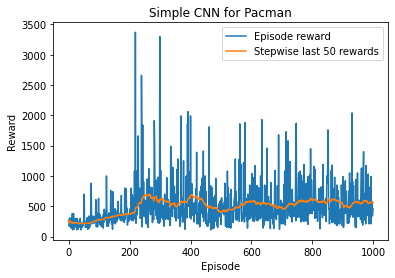

In [ ]:
import matplotlib.pyplot as plt

plt.plot(all_rewards, label='Episode reward')
plt.plot(avg_rewards, label='Stepwise last 50 rewards')
plt.title('Simple CNN for Pacman')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.legend()
plt.show()

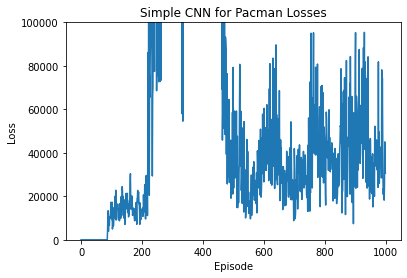

In [ ]:
plt.plot(all_losses)
plt.title("Simple CNN for Pacman Losses")
plt.xlabel('Episode')
plt.ylabel('Loss')
plt.ylim([0, 100000])
plt.show()

In [ ]:
np.save('pac_all_rewards_simple', all_rewards)
np.save('pac_50_avg_rewards_simple', avg_rewards)
np.save('pac_losses_simple', all_losses)

### More complex CNN

In [ ]:
env2 = gym.make('ALE/MsPacman-v5')
# A more complex one
agt2 = Agent(env2, DQN2)


In [ ]:
total_step2 = 0
all_rewards2 = []
last_50_rewards2 = deque(maxlen=50)
avg_rewards2 = []
all_losses2 = []

t0 = time.time()
for episode in range(1000):
    startT = time.time()

    state = agt2.processImage(env2.reset())
    state = np.stack((state, state, state, state))[None, :]
    total_r = 0
    total_loss = torch.tensor([0.0], dtype=torch.float, device=cuda0)
    for step in range(100000):

        action = agt2.predict(state)
        next_state, reward, done, _ = env2.step(action)
        next_state = agt2.processImage(next_state)
        next_state = np.stack((next_state,state[0][1],state[0][2],state[0][3]))[None, :]
        agt2.collect_experience(state, action, reward, next_state, done)
        state = next_state

        loss = agt2.train()
        total_loss += loss
        total_r += reward
        total_step2 += 1
        if total_step2 % 1000 == 0:
          agt2.adaptEpsilon()

        if done:
            # Save model
            finishT = time.time()
            all_rewards2.append(total_r)
            last_50_rewards2.append(total_r)
            avg_r = np.mean(last_50_rewards2)
            avg_rewards2.append(avg_r)
            all_losses2.append(total_loss.item())
            if (episode+1) % 50 == 0:
                w_path = './pacman2_cnn_' + str(episode+1) + '.pkl'
                epsilon_path = './pacman2_cnn_' + str(episode+1) + '.json'
                epsilon_dict = {'epsilon': agt2.epsilon, 'rewards': all_rewards2, 'average': avg_rewards2}
                torch.save(agt2.mdl.state_dict(), w_path)
                f_epsilon = open(epsilon_path, 'w')
                json.dump(epsilon_dict, f_epsilon)
                f_epsilon.close()

            print("Total step:", total_step2)
            print("Episode", episode, "    Training time:", finishT - startT, " Total time elapsed:", finishT - t0)
            print("Reward:", total_r, " Average reward (last 50):", avg_r, " Loss:", total_loss.item(), " Epsilon:", agt2.epsilon)

            break

Total step: 522
Episode 0     Training time: 0.3750901222229004  Total time elapsed: 0.37538957595825195
Reward: 210.0  Average reward (last 50): 210.0  Loss: 0.0  Epsilon: 1
Total step: 962
Episode 1     Training time: 0.32576560974121094  Total time elapsed: 0.7048919200897217
Reward: 270.0  Average reward (last 50): 240.0  Loss: 0.0  Epsilon: 1
Total step: 1452
Episode 2     Training time: 0.3839249610900879  Total time elapsed: 1.0925076007843018
Reward: 360.0  Average reward (last 50): 280.0  Loss: 0.0  Epsilon: 0.99
Total step: 1922
Episode 3     Training time: 0.3585703372955322  Total time elapsed: 1.4555308818817139
Reward: 190.0  Average reward (last 50): 257.5  Loss: 0.0  Epsilon: 0.99
Total step: 2512
Episode 4     Training time: 0.47468090057373047  Total time elapsed: 1.9343674182891846
Reward: 270.0  Average reward (last 50): 260.0  Loss: 0.0  Epsilon: 0.9801
Total step: 2990
Episode 5     Training time: 0.36188650131225586  Total time elapsed: 2.2999486923217773
Reward:

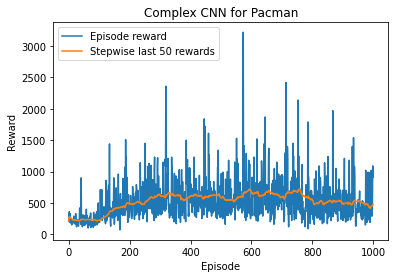

In [ ]:
plt.plot(all_rewards2, label='Episode reward')
plt.plot(avg_rewards2, label='Stepwise last 50 rewards')
plt.title('Complex CNN for Pacman')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.legend()
plt.show()

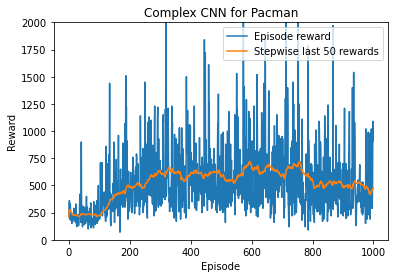

In [ ]:
plt.plot(all_rewards2, label='Episode reward')
plt.plot(avg_rewards2, label='Stepwise last 50 rewards')
plt.title('Complex CNN for Pacman')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.ylim([0, 2000])
plt.legend()
plt.show()

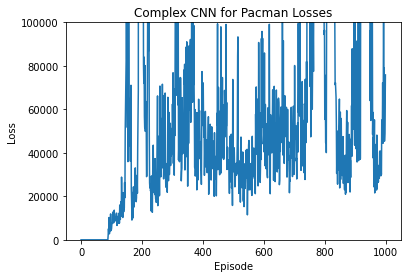

In [ ]:
plt.plot(all_losses2)
plt.title("Complex CNN for Pacman Losses")
plt.xlabel('Episode')
plt.ylabel('Loss')
plt.ylim([0, 100000])
plt.show()

In [ ]:
np.save('pac_all_rewards_complex', all_rewards2)
np.save('pac_50_avg_rewards_complex', avg_rewards2)
np.save('pac_losses_complex', all_losses2)

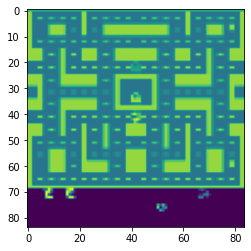

In [ ]:
plt.imshow(state[0][1])

### Update image processing method

In [ ]:
MAX_REPLAY_SIZE2 = 30000
MIN_REPLAY_SIZE2 = 20000


class Agent2:
    def __init__(self, env, DQN_TYPE):
        self.env = env
        self.state_h = env.observation_space.shape[0]
        self.state_w = env.observation_space.shape[1]
        self.action_n = env.action_space.n
        self.replay = deque(maxlen=MAX_REPLAY_SIZE2)
        self.step = 0
        self.epsilon = 1

        self.mdl = DQN_TYPE(4, self.action_n).to(cuda0)
        self.target_mdl = DQN_TYPE(4, self.action_n).to(cuda0)
        self.optimizer = optim.Adam(self.mdl.parameters(), lr=0.0001)

    def processImage(self, img):
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img_gray = cv2.resize(img_gray, (84, 103))
        return img_gray[0:84]

    def predict(self, state):
        if random.uniform(0, 1) <= self.epsilon:
          return random.randrange(self.action_n)
        with torch.no_grad():
            state_t = torch.tensor(state, dtype=torch.float, device=cuda0)
            vals = self.mdl.forward(state_t)
            next_action = torch.argmax(vals).item()

        return next_action

    def collect_experience(self, state, action, reward, next_state, done):
        self.replay.append((state, action, reward, next_state, done))

    def train(self):
        if len(self.replay) < MIN_REPLAY_SIZE2:
            return 0
        s, a, r, n_s, done = zip(*random.sample(self.replay, BATCH_SIZE))
        s = np.concatenate(s)
        n_s = np.concatenate(n_s)
        r = torch.tensor(r, dtype=torch.float, device=cuda0)
        done = torch.tensor(done, dtype=torch.float, device=cuda0)
        q_vals_all = self.mdl(torch.tensor(s, dtype=torch.float, device=cuda0))
        next_q_vals_all = self.target_mdl(torch.tensor(n_s, dtype=torch.float, device=cuda0))
        q_vals_selected = q_vals_all.gather(1, torch.tensor(a, dtype=torch.int64, device=cuda0).unsqueeze(1)).squeeze(1).to(cuda0)
        next_q_vals_max = next_q_vals_all.gather(1, next_q_vals_all.max(1)[1].unsqueeze(1)).squeeze(1).to(cuda0)
        G = r + 0.97 * next_q_vals_max * (1 - done)

        loss = (q_vals_selected - G.detach()).pow(2).mean()
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        self.step += 1

        if self.step % 50 == 0:
          self.target_mdl.load_state_dict(self.mdl.state_dict())

        return loss

    def adaptEpsilon(self):
        if self.epsilon > 0.05:
            self.epsilon *= 0.99


In [ ]:
env3 = gym.make('ALE/MsPacman-v5')
agt3 = Agent2(env3, DQN2)

In [ ]:
total_step3 = 0
all_rewards3 = []
last_50_rewards3 = deque(maxlen=50)
avg_rewards3 = []
all_losses3 = []

t0 = time.time()
for episode in range(1000):
    startT = time.time()

    state = agt3.processImage(env3.reset())
    state = np.stack((state, state, state, state))[None, :]
    total_r = 0
    total_loss = torch.tensor([0.0], dtype=torch.float, device=cuda0)
    for step in range(100000):

        action = agt3.predict(state)
        next_state, reward, done, _ = env3.step(action)
        next_state = agt3.processImage(next_state)
        next_state = np.stack((next_state,state[0][1],state[0][2],state[0][3]))[None, :]
        agt3.collect_experience(state, action, reward, next_state, done)
        state = next_state

        loss = agt3.train()
        total_loss += loss
        total_r += reward
        total_step3 += 1
        if total_step3 % 1500 == 0:
          agt3.adaptEpsilon()

        if done:
            # Save model
            finishT = time.time()
            all_rewards3.append(total_r)
            last_50_rewards3.append(total_r)
            avg_r = np.mean(last_50_rewards3)
            avg_rewards3.append(avg_r)
            all_losses3.append(total_loss.item())
            if (episode+1) % 50 == 0:
                w_path = './pacman3_cnn_' + str(episode+1) + '.pkl'
                epsilon_path = './pacman3_cnn_' + str(episode+1) + '.json'
                epsilon_dict = {'epsilon': agt3.epsilon, 'rewards': all_rewards3, 'average': avg_rewards3}
                torch.save(agt3.mdl.state_dict(), w_path)
                f_epsilon = open(epsilon_path, 'w')
                json.dump(epsilon_dict, f_epsilon)
                f_epsilon.close()

            print("Total step:", total_step3)
            print("Episode", episode, "    Training time:", finishT - startT, " Total time elapsed:", finishT - t0)
            print("Reward:", total_r, " Average reward (last 50):", avg_r, " Loss:", total_loss.item(), " Epsilon:", agt3.epsilon)

            break

Total step: 492
Episode 0     Training time: 0.8799326419830322  Total time elapsed: 0.880434513092041
Reward: 260.0  Average reward (last 50): 260.0  Loss: 0.0  Epsilon: 1
Total step: 928
Episode 1     Training time: 0.6131720542907715  Total time elapsed: 1.504216194152832
Reward: 260.0  Average reward (last 50): 260.0  Loss: 0.0  Epsilon: 1
Total step: 1548
Episode 2     Training time: 1.2805497646331787  Total time elapsed: 2.78533935546875
Reward: 210.0  Average reward (last 50): 243.33333333333334  Loss: 0.0  Epsilon: 0.99
Total step: 2162
Episode 3     Training time: 1.1184649467468262  Total time elapsed: 3.90899658203125
Reward: 460.0  Average reward (last 50): 297.5  Loss: 0.0  Epsilon: 0.99
Total step: 2658
Episode 4     Training time: 0.9015161991119385  Total time elapsed: 4.81550145149231
Reward: 260.0  Average reward (last 50): 290.0  Loss: 0.0  Epsilon: 0.99
Total step: 3234
Episode 5     Training time: 0.905083179473877  Total time elapsed: 5.726275205612183
Reward: 32

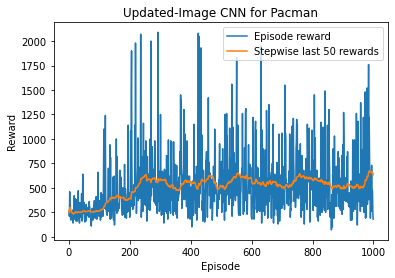

In [ ]:
plt.plot(all_rewards3, label='Episode reward')
plt.plot(avg_rewards3, label='Stepwise last 50 rewards')
plt.title('Updated-Image CNN for Pacman')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.legend()
plt.show()

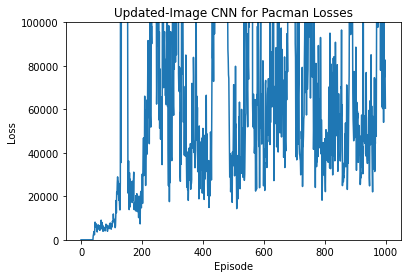

In [ ]:
plt.plot(all_losses3)
plt.title("Updated-Image CNN for Pacman Losses")
plt.xlabel('Episode')
plt.ylabel('Loss')
plt.ylim([0, 100000])
plt.show()

In [ ]:
np.save('pac_all_rewards_updated', all_rewards3)
np.save('pac_50_avg_rewards_updated', avg_rewards3)
np.save('pac_losses_updated', all_losses3)